Project: Prediction of Hammett Parameters using Molecular Structural Information
Date: 08/16/2018

Install rdkit in Anaconda environment (https://www.rdkit.org/docs/GettingStartedInPython.html)

In [2]:
#Packages to read and manipulate molecular structural information
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
#Read sdf file containing structural information of ligand database
ligands =Chem.SDMolSupplier('C:/Users/banst/Google Drive/USC Acad/Chemistry_ML/ligands')

In [6]:
#Import packages for molecular decriptors and fingerprints (refer to rdkit tutorial)
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols

In [7]:
# Import data analysis tools
import pandas as pd
import numpy as np

In [8]:
# Read input database file in csv format
input=pd.read_csv('C:/Users/banst/Google Drive/USC Acad/Chemistry_ML/input.csv')

In [9]:
input.shape

(395, 7)

In [33]:
# Define output Y
Y=input[['Hammett Constant']].copy()
# Define variables for isomer type and dipole moments from input
Isomer=input[['Isomer']].copy()
#Dipole=input[['Dipole']].copy()

In [13]:
# MACCS keys
from rdkit.Chem import MACCSkeys

In [14]:
#Generate MACC fingerprint for ligands
macc= [MACCSkeys.GenMACCSKeys(x) for x in ligands]

In [17]:
#Gnerate ECFP fingerprint for ligands [length=1024]
morgan=[AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=1024) for x in ligands]
#convert fingerprint to np array
efp=np.array(morgan)
efp.shape

(395L, 1024L)

In [19]:
#Define input
X=np.concatenate((efp,Isomer),axis=1)
#X=np.concatenate((X,Dipole),axis=1)
X.shape

(395L, 1025L)

In [26]:
#Normalize input dataset to mean=0 and sd=1
from sklearn import preprocessing
X=preprocessing.normalize(X)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

Define Bootstrap Function: Generates a indices randomly

In [28]:
def bootstrap_resample(X, n=None):
   
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    i= resample_i
    return i

Regularizarion: Define an array for regularization parameter alpha,
Develop ANN fits for all alpha values and calculate the Mean squared errors for each,
Plot MSE vs alpha to find optimum value for regularization parameter,
MSE formula:
MSE(total)=0.3698(MSE_train)+(0.632MSE_test)

In [45]:
#Creating training set
i = bootstrap_resample(X,n=None)
train=X[i]
test=np.delete(X,i,axis=0)
Y=np.array(Y)
Y_train=Y[i]
Y_test=np.delete(Y,i,axis=0)

In [46]:
#Define null arrays
MSE_reg=np.zeros(10)
MSE_train=np.zeros(10)
MSE_test=np.zeros(10)
#Define alpha array
a=[0.01,0.03,0.05,0.07,0.09,0.11,0.13,0.15,0.17,0.19]
#Fit neural network
for j in range(0,10):
    mlp_resample = MLPRegressor(hidden_layer_sizes=(250),alpha = a[j])   #ANN fit
    mlp_resample.fit(train,Y_train)
    Y_pred_test=mlp_resample.predict(test)   
    Y_pred_train=mlp_resample.predict(train)
    MSE_train[j]=mean_squared_error(Y_train, Y_pred_train)
    MSE_test[j]= mean_squared_error(Y_test, Y_pred_test)
    MSE_reg[j]=(MSE_train[j]*0.368)+(0.632)*(MSE_test[j])
    

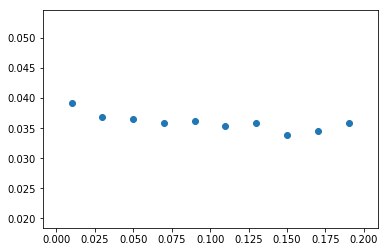

In [47]:
#Plot Error vs alpha
plt.scatter(a,MSE_reg)

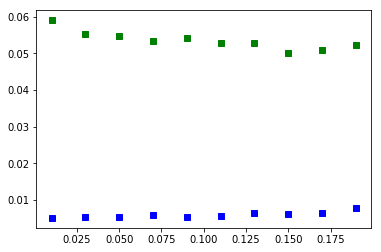

In [48]:
plt.plot(a,MSE_train,'bs',a,MSE_test,'gs')


In [37]:
import matplotlib.pyplot as plt

In [41]:
#Define null arrays
MSE_boot=np.zeros((250),dtype= float)
Index= np.zeros((250,395),dtype=int)

In [43]:
#Store bootstrap outputs
Y_prediction=np.zeros(395).T

In [44]:
#Define ANN model with 250 hidden neurons and alpha =0.05
mlp_resample = MLPRegressor(hidden_layer_sizes=(250),alpha = 0.05)

In [47]:
#Bootstrap resampling

for m in range(0,250):
    ind = bootstrap_resample(X,n=116) #Call bootstrap to randomly select index
    Index[m]=ind
    X_resample= X[ind]
    Y_resample= Y[ind]
    X_testbsr=np.delete(X,ind,axis=0)
    Y_testbsr=np.delete(Y,ind,axis=0)
    #ANN
    mlp_resample.fit(X_resample,Y_resample)
    Y_pred_resample=mlp_resample.predict(X_testbsr)  #Fit ANN on test
    Y_pred_train=mlp_resample.predict(X_resample)    #Fit ANN on training set
    Y_pred_all[:,m]=mlp_resample.predict(X)          # Fit ANN on complete database
    MSE_train=mean_squared_error(Y_resample, Y_pred_train)
    MSE_test= mean_squared_error(Y_testbsr, Y_pred_resample)
    MSE_boot[m]=(MSE_train*0.368)+(0.632)*(MSE_test)

In [ ]:
min(MSE_boot)

In [ ]:
#Save errors and Y predictions in csv files
pd.DataFrame(MSE_boot).to_csv('MSE_boot.csv')
pd.DataFrame(Y_pred_all).to_csv('Y_pred_all.csv')

Calculate 95% Confidence intervals over entire Bootstrap runs

In [ ]:
#Confidence intervals
d=np.sort(Y_pred_all)
alpha=0.95
lower=np.zeros(395)
upper=np.zeros(395)
mean=np.mean(d,axis=1)
p = ((1.0-alpha)/2.0) * 100
q = (alpha+((1.0-alpha)/2.0)) * 100
for j in range(0,395):
    min_=min(d[j])
    max_=max(d[j])
    lower[j] = max(min_, np.percentile(d[j,:], p)) #Lower limit
    upper[j]=min(max_, np.percentile(d[j,:], q))   #Upper limit
    

In [ ]:
#Store limits in csv
pd.DataFrame(lower).to_csv('lowerlimit.csv')
pd.DataFrame(upper).to_csv('upperlimit.csv')
pd.DataFrame(mean).to_csv('means.csv')

In [ ]:
plt.plot(MSE_boot)

In [ ]:
b=np.argmin(MSE_boot)
min_index=Index[b]
min_index=np.array(min_index)

In [ ]:
train_best= X[min_index]
train_best.shape
Y_best_train= Y[min_index]

In [ ]:
#Predicting output for model with least error
mlp_resample.fit(train_best,Y_best_train)
Y_prediction=mlp2.predict(X)

In [ ]:
plt.scatter(Y_test,Y_prediction)

In [ ]:
#Save output in csv
pd.DataFrame(Y_test).to_csv('Y_test.csv')
pd.DataFrame(Y_prediction).to_csv('Y_prediction.csv')
